# Imports

In [1]:
import numpy as np
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from datasets import load_dataset
torch.set_printoptions(linewidth=160)
from torch import nn
from torch.nn import functional as F
from torchvision.utils import save_image


# Butterfly dataset

In [2]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_filepath=r"/home/sriyar/ADRL_Assignment2/butterflies_data/2/Training_set.csv" 
dataset_filepath_test=r"/home/sriyar/ADRL_Assignment2/butterflies_data/2/Testing_set.csv" 

data_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor() ,
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[1.0, 1.0, 1.0])  
])

dataset_train = load_dataset('csv', data_files=dataset_filepath)
dataset_test = load_dataset('csv', data_files=dataset_filepath_test)


# Function transform the image
def transform_image_train(data):
    image = Image.open('/home/sriyar/ADRL_Assignment2/butterflies_data/2/train/'+data['filename'])
    data['image'] = data_transforms(image)
    return data
# Function transform the image
def transform_image_test(data):
    image = Image.open('/home/sriyar/ADRL_Assignment2/butterflies_data/2/test/'+data['filename'])
    data['image'] = data_transforms(image)
    return data
dataset_train = dataset_train.map(transform_image_train)

dataset_test = dataset_test.map(transform_image_test)
dataset_train.set_format(type='torch', columns=['image'])
print(dataset_train)
dataset_test.set_format(type='torch', columns=['image'])
print(dataset_test)

dataloader_butterfly_train = DataLoader(dataset_train['train'], batch_size=64, shuffle=True, num_workers=5)
dataloader_butterfly_test = DataLoader(dataset_test['train'], batch_size=64, shuffle=True, num_workers=5)


# Calculate the variance of the training dataset
all_images = []

with torch.no_grad():
    for batch in dataloader_butterfly_train:
        images = batch['image']
        images = images.view(images.size(0), -1)  # Flatten the images
        all_images.append(images.cpu())

all_images = torch.cat(all_images)
all_images = all_images 
train_data_variance = np.var(all_images.numpy())
print("Variance of the training dataset:", train_data_variance)

DatasetDict({
    train: Dataset({
        features: ['filename', 'label', 'image'],
        num_rows: 6499
    })
})
DatasetDict({
    train: Dataset({
        features: ['filename', 'image'],
        num_rows: 2786
    })
})
Variance of the training dataset: 0.07239691


# Class VQVAE

In [3]:


class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
     
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=3,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)


class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            else:
                (in_channels, out_channels) = (num_hiddens // 2, 3)

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return x_recon


class SonnetExponentialMovingAverage(nn.Module):

    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay ** self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average


class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
     
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        self.decay = decay
        self.epsilon = epsilon

        limit = 3 ** 0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x ** 2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts ** 2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. 
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                self.N_i_ts(n_i_ts)

                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

              
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, _) = self.quantize(x)
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
        }
    


In [4]:
# Initialize model.
device = torch.device("cuda:0")
use_ema = True
model_args = {
    "in_channels": 3,
    "num_hiddens": 128,
    "num_downsampling_layers": 2,
    "num_residual_layers": 2,
    "num_residual_hiddens": 32,
    "embedding_dim": 128,
    "num_embeddings": 512,
    "use_ema": use_ema,
    "decay": 0.99,
    "epsilon": 1e-5,
}
model = VQVAE(**model_args).to(device)

# Train VQVAE

In [5]:
beta = 0.1

# Initialize optimizer.
train_params = [params for params in model.parameters()]
lr = 0.0005
optimizer = optim.Adam(train_params, lr=lr)
criterion = nn.MSELoss()

# Train model.
epochs = 100
eval_every = 100
best_train_loss = float("inf")
model.train()

VQVAE(
  (encoder): Encoder(
    (conv): Sequential(
      (down0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (relu0): ReLU()
      (down1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (relu1): ReLU()
      (final_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (residual_stack): ResidualStack(
      (layers): ModuleList(
        (0-1): 2 x Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
  )
  (pre_vq_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (vq): VectorQuantizer(
    (N_i_ts): SonnetExponentialMovingAverage()
    (m_i_ts): SonnetExponentialMovingAverage()
  )
  (decoder): Decoder(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (residual_stack): ResidualStack(


In [6]:
import os
os.makedirs('./results_rec_vqvae', exist_ok=True)
os.makedirs('./results_gen_vqvae', exist_ok=True)

In [16]:
import os

# Specify the directory to save your model
model_save_path = './saved_models'
os.makedirs(model_save_path, exist_ok=True)

for epoch in range(epochs):
    total_train_loss = 0
    total_recon_error = 0
    n_train = 0

    for i, x in enumerate(dataloader_butterfly_train):
        imgs = x['image'].cuda()  # Get the image tensor
        imgs = imgs.to(device)

        out = model(imgs)

        recon_error = criterion(out["x_recon"], imgs) / train_data_variance
        total_recon_error += recon_error.item()
        loss = recon_error + beta * out["commitment_loss"]
        if not use_ema:
            loss += out["dictionary_loss"]

        total_train_loss += loss.item()
        optimizer.zero_grad()  # Reset gradients
        loss.backward()
        optimizer.step()
        n_train += 1

        if (i + 1) % eval_every == 0:
            print(f"epoch: {epoch}\nbatch_idx: {i + 1}", flush=True)
            avg_train_loss = total_train_loss / n_train if n_train > 0 else 0
            if avg_train_loss < best_train_loss:
                best_train_loss = avg_train_loss

            print(f"total_train_loss: {avg_train_loss}")
            print(f"best_train_loss: {best_train_loss}")
            print(f"recon_error: {total_recon_error / n_train}\n")

            total_train_loss = 0
            total_recon_error = 0
            n_train = 0

            with torch.no_grad():
                model.eval()
                x_rec = model(imgs)['x_recon']
                imgs_array = torch.clamp(x_rec, min=-0.5, max=0.5) + 0.5

                # Save reconstructed images
                print(f'Reconstructed Images - Size: {imgs_array.size()}, Min: {imgs_array.min().item()}, Max: {imgs_array.max().item()}')
                save_image(imgs_array.cpu(), f'./results_rec_vqvae/sample_{epoch}_{i}.png')
                
                '''# Generate images from quantized representation
                z_quantized, dictionary_loss, commitment_loss, encoding_indices = model.vq(sample1)
                generated_images = model.decoder(sample1)
                
                # Resize generated images to 128x128
                generated_images = torch.nn.functional.interpolate(generated_images, size=(128, 128), mode='bilinear', align_corners=False)
                
                # Normalize resized images to [0, 1]
                min_val, max_val = generated_images.min(), generated_images.max()
                generated_images = (generated_images - min_val) / (max_val - min_val + 1e-5)
                
                # Save normalized generated images
                print(f'Generated Images - Size: {generated_images.size()}, Min: {generated_images.min().item()}, Max: {generated_images.max().item()}')
                save_image(generated_images.cpu(), f'./results_gen_vqvae/sample_{epoch}_{i}.png')
                '''

# Save the trained model after all epochs
torch.save(model.state_dict(), os.path.join(model_save_path, 'vqvae_model_final.pth'))
print("Model saved successfully at ./saved_models/vqvae_model_final.pth")


'\nfor epoch in range(epochs):\n    total_train_loss = 0\n    total_recon_error = 0\n    n_train = 0\n\n    for i, x in enumerate(dataloader_butterfly_train):\n        imgs = x[\'image\'].cuda()  # Get the image tensor\n        imgs = imgs.to(device)\n\n        out = model(imgs)\n\n        recon_error = criterion(out["x_recon"], imgs) / train_data_variance\n        total_recon_error += recon_error.item()\n        loss = recon_error + beta * out["commitment_loss"]\n        if not use_ema:\n            loss += out["dictionary_loss"]\n\n        total_train_loss += loss.item()\n        optimizer.zero_grad()  # Reset gradients\n        loss.backward()\n        optimizer.step()\n        n_train += 1\n\n        if (i + 1) % eval_every == 0:\n            print(f"epoch: {epoch}\nbatch_idx: {i + 1}", flush=True)\n            avg_train_loss = total_train_loss / n_train if n_train > 0 else 0\n            if avg_train_loss < best_train_loss:\n                best_train_loss = avg_train_loss\n\n    

## Reconstructed images
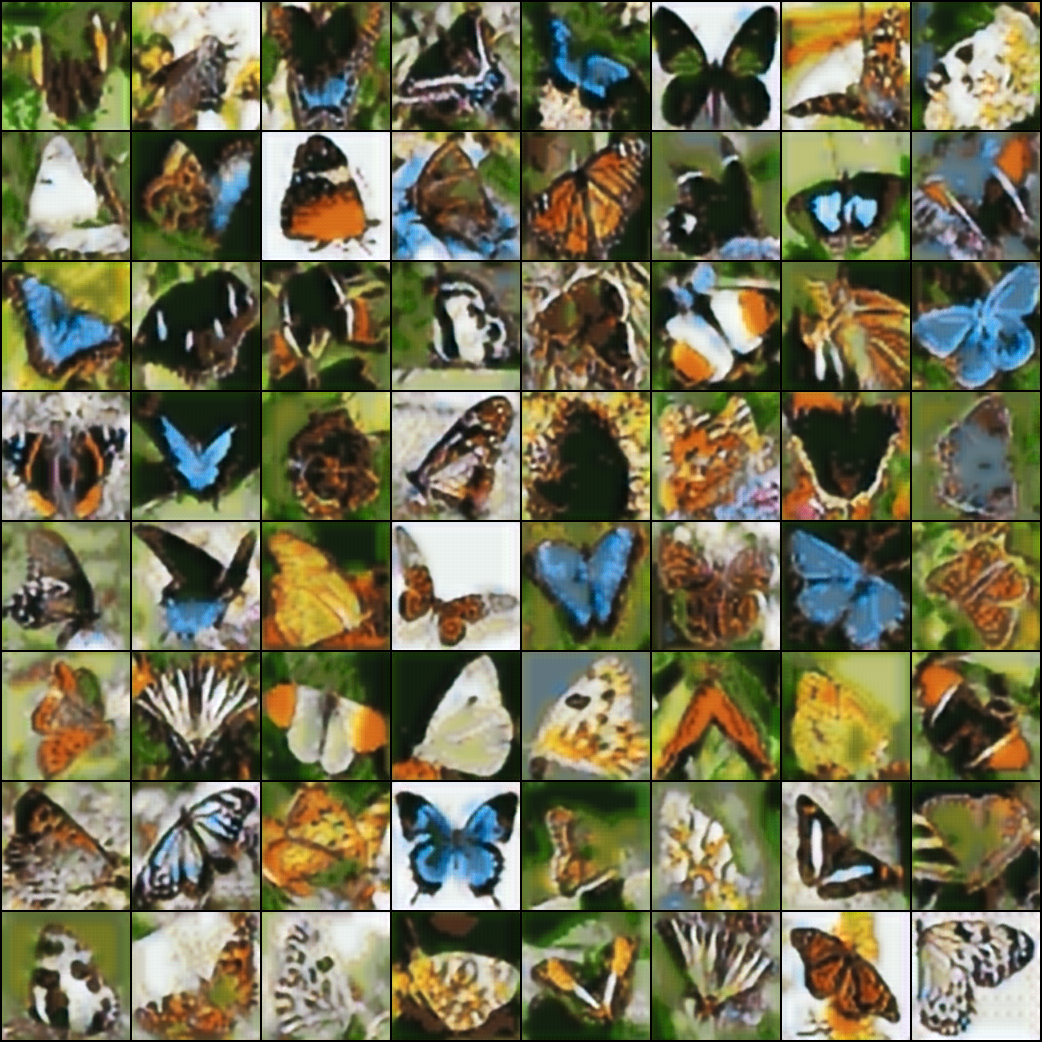

## Posterior Inference

In [8]:
import torch

# Load the saved model state dictionary
model = VQVAE(**model_args).to(device)
model.load_state_dict(torch.load('./saved_models/vqvae_model_final.pth'))
model.eval().to(device)  # Set model to evaluation mode and move to device if using GPU


/tmp/ipykernel_247558/373492231.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./saved_models/vqvae_model_final.pth'))


VQVAE(
  (encoder): Encoder(
    (conv): Sequential(
      (down0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (relu0): ReLU()
      (down1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (relu1): ReLU()
      (final_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (residual_stack): ResidualStack(
      (layers): ModuleList(
        (0-1): 2 x Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
  )
  (pre_vq_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (vq): VectorQuantizer(
    (N_i_ts): SonnetExponentialMovingAverage()
    (m_i_ts): SonnetExponentialMovingAverage()
  )
  (decoder): Decoder(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (residual_stack): ResidualStack(


In [9]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from datasets import load_dataset
from PIL import Image
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# File paths
dataset_filepath = r"/home/sriyar/ADRL_Assignment2/butterflies_data/2/Training_set.csv"
dataset_filepath_test = r"/home/sriyar/ADRL_Assignment2/butterflies_data/2/Testing_set.csv"

# Define image transformations
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[1, 1, 1])
])

# Load datasets
dataset_train = load_dataset('csv', data_files=dataset_filepath)

# Create a mapping from labels to indices
label_to_idx = {label: idx for idx, label in enumerate(set(dataset_train['train']['label']))}

# Function to transform images and labels for training dataset
def transform_image_train(data):
    image = Image.open('/home/sriyar/ADRL_Assignment2/butterflies_data/2/train/' + data['filename'])
    data['image'] = data_transforms(image)
    data['label'] = label_to_idx[data['label']]  # Convert string label to index
    return data

# Apply transformations to the datasets
dataset_train = dataset_train.map(transform_image_train)

# Set format for PyTorch tensors
dataset_train.set_format(type='torch', columns=['image', 'label'])

# Split the training dataset into train, validation, and test sets
train_size = int(1 * len(dataset_train['train']))  
val_size = int(0.0 * len(dataset_train['train']))   
test_size = len(dataset_train['train']) - train_size - val_size  
train_dataset, val_dataset, test_dataset = random_split(dataset_train['train'], [train_size, val_size, test_size])

# Create DataLoaders
dataloader_butterfly_train = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=5)
dataloader_butterfly_val = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=5)
dataloader_butterfly_test = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=5)

# Count unique classes in the training dataset
num_classes = len(label_to_idx)  # Unique class count from the mapping
print(f"Number of classes: {num_classes}")


Map:   0%|          | 0/6499 [00:00<?, ? examples/s]

Number of classes: 75


In [10]:
from torch.utils.data import DataLoader

# Assuming dataloader_butterfly_train is your training dataset loader
all_latent_vectors = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for data in dataloader_butterfly_train:
        images = data['image'].to(device)
        labels = data['label'].to(device)
        
        # Pass through the encoder and pre_vq_conv to get the latent vectors
        encoded = model.encoder(images)
        latent_vectors = model.pre_vq_conv(encoded).flatten(start_dim=1)  # Flatten spatial dimensions

        # Collect the latent vectors and labels
        all_latent_vectors.append(latent_vectors.cpu())
        all_labels.append(labels)

# Convert list to tensors for easier manipulation
all_latent_vectors = torch.cat(all_latent_vectors, dim=0)
all_labels = torch.cat(all_labels, dim=0)


In [12]:
import torch
from sklearn.model_selection import train_test_split

# Assume all_latent_vectors and all_labels are already defined
# Convert them to numpy arrays for easier splitting
latent_vectors_np = all_latent_vectors.cpu().numpy()  # Move to CPU first
labels_np = all_labels.cpu().numpy()  # Move to CPU first


# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    latent_vectors_np, labels_np, test_size=0.05, random_state=42, stratify=labels_np
)

# Split the train set into train and validation sets (80% train, 20% validation of the train set)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.05, random_state=42, stratify=y_train
)

# Convert back to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Now you have:
# X_train_tensor, y_train_tensor for training
# X_val_tensor, y_val_tensor for validation
# X_test_tensor, y_test_tensor for testing

# You can create DataLoaders for each set
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

dataloader_butterfly_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_butterfly_val = DataLoader(val_dataset, batch_size=32, shuffle=False)
dataloader_butterfly_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Now you can use these DataLoaders for training your classifier


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the LatentCNNClassifier class
class LatentCNNClassifier(nn.Module):
    def __init__(self, num_classes, latent_dim):
        super(LatentCNNClassifier, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)  # Increased hidden layer size
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = X_train_tensor.size(1)  # Size of latent dimension
num_classes = len(set(y_train_tensor.numpy()))  # Number of classes
model = LatentCNNClassifier(num_classes=num_classes, latent_dim=latent_dim).to(device)

# Training loop with early stopping and learning rate scheduler
num_epochs = 200  # Total number of epochs
best_val_loss = float('inf')  # Initialize best validation loss
patience = 10  # Number of epochs with no improvement after which training will be stopped
counter = 0  # Counter for early stopping
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Optimizer
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Create DataLoaders
dataloader_butterfly_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_butterfly_val = DataLoader(val_dataset, batch_size=32, shuffle=False)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for batch in dataloader_butterfly_train:
        latent_vectors, labels = batch  # Unpack batch
        latent_vectors, labels = latent_vectors.to(device), labels.to(device)

        # Add small random noise to the input for robustness
        noisy_latent_vectors = latent_vectors + 0.1 * torch.randn_like(latent_vectors)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model(noisy_latent_vectors)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(dataloader_butterfly_train):.4f}")

    # Validation Step
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader_butterfly_val:
            latent_vectors, labels = batch  # Unpack batch
            latent_vectors, labels = latent_vectors.to(device), labels.to(device)
            outputs = model(latent_vectors)
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()  # Accumulate validation loss
            _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
            total += labels.size(0)  # Update total count
            correct += (predicted == labels).sum().item()  # Update correct predictions

    avg_val_loss = val_loss / len(dataloader_butterfly_val)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy on val data: {accuracy:.2f}%")

    # Early stopping and learning rate scheduling
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Update best validation loss
        counter = 0  # Reset counter
        torch.save(model.state_dict(), 'best_latent_model.pth')  # Save the model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


/home/sriyar/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Training Loss: 4.1220
Validation Loss: 3.7846, Accuracy on val data: 12.94%
Epoch [2/200], Training Loss: 3.6135
Validation Loss: 3.3020, Accuracy on val data: 18.77%
Epoch [3/200], Training Loss: 3.3043
Validation Loss: 3.0606, Accuracy on val data: 22.33%
Epoch [4/200], Training Loss: 3.0982
Validation Loss: 2.8717, Accuracy on val data: 26.21%
Epoch [5/200], Training Loss: 2.9567
Validation Loss: 2.7576, Accuracy on val data: 28.16%
Epoch [6/200], Training Loss: 2.8701
Validation Loss: 2.6555, Accuracy on val data: 31.07%
Epoch [7/200], Training Loss: 2.7701
Validation Loss: 2.5685, Accuracy on val data: 30.10%
Epoch [8/200], Training Loss: 2.6743
Validation Loss: 2.5015, Accuracy on val data: 35.92%
Epoch [9/200], Training Loss: 2.6538
Validation Loss: 2.4437, Accuracy on val data: 36.89%
Epoch [10/200], Training Loss: 2.6064
Validation Loss: 2.4508, Accuracy on val data: 38.19%
Epoch [11/200], Training Loss: 2.5373
Validation Loss: 2.3764, Accuracy on val data: 41.1

In [14]:

# Evaluate on the test set (optional)
model.load_state_dict(torch.load('best_latent_model.pth'))  # Load the best model
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
# Create test DataLoader if needed
dataloader_butterfly_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for batch in dataloader_butterfly_test:
        latent_vectors, labels = batch  # Unpack batch
        latent_vectors, labels = latent_vectors.to(device), labels.to(device)
        outputs = model(latent_vectors)
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct predictions

print(f"Accuracy on test data: {100 * correct / total:.2f}%")


/tmp/ipykernel_247558/1358902543.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_latent_model.pth'))  # Load the best model


Accuracy on test data: 39.38%


Q8.Fit GMM

In [ ]:
print(all_latent_vectors.shape)

torch.Size([6499, 131072])


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA 

num_gmm_components = 30  
gmm = GaussianMixture(n_components=num_gmm_components,covariance_type='diag') 
pca=PCA(n_components=512)
latent_vec=pca.fit_transform(all_latent_vectors)
gmm.fit(latent_vec)

num_samples = 100  
sampled_latent_vectors = gmm.sample(num_samples)[0]  # shape: [num_samples, feature_dim]
latent_samples = torch.tensor(pca.inverse_transform(sampled_latent_vectors), dtype=torch.float32).to(device)
sampled_latent_vectors_reshaped = torch.tensor(latent_samples, dtype=torch.float32).view(num_samples, 128, 32, 32).to(device)

model.eval()
with torch.no_grad():
    generated_images = model.decoder(sampled_latent_vectors_reshaped)

def plot_images(images, nrows, ncols):
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for ax in axs.flatten():
        ax.axis('off')
    for i, img in enumerate(images):
        if i >= nrows * ncols:
            break
        ax = axs.flatten()[i]
        img = img.detach().cpu().numpy() 
        img = (img * 255).astype(np.uint8)  
        ax.imshow(img.transpose(1, 2, 0))  
    plt.tight_layout()
    plt.show()

plot_images(generated_images, nrows=10, ncols=10)